# Setup

In [1]:
import os

os.system("docker start psg")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from astropy.constants import R_earth

from geexhp import datagen, datamod, datavis
from geexhp import stages as st_
datavis.configure_matplotlib(oldschool=False)

psg


In [2]:
def get_config_data(stage="modern"):
    dg = datagen.DataGen(stage=stage)
    config_str = dg.config_str
    config_dict = dg._parse_config(config_str)
    datamod.mixing_ratio_constant(config_dict, 60)
    datamod.normalize_layer(config_dict, 60, st_.molweightlist(era=stage))
    return dg, config_dict

# The Earth at different distances

In [3]:
def _get_spectra_data(config, instrument, save_path, distance=None, gas=None, multiplier=0):

    modified_config = config.copy()

    if distance is not None:
        modified_config['GEOMETRY-OBS-ALTITUDE'] = distance

    if gas is not None:
        elements = modified_config.get("ATMOSPHERE-LAYERS-MOLECULES", "").split(",")
        if gas in elements:
            gas_index = elements.index(gas) 
            
            for key, value in modified_config.items():
                if key.startswith("ATMOSPHERE-LAYER-"): 
                    values = value.split(',')
                    gas_value = float(values[gas_index + 2])
                    new_value = gas_value * multiplier 
                    values[gas_index + 2] = str(new_value)
                    modified_config[key] = ','.join(values)
    else:
        pass

    config = get_config_data()[0]._serialize_config(modified_config)
    
    data_list = []

    for i in instrument:
        wavelength, total, noise, _ = get_config_data()[0]._generate_spectrum_for_instrument(config, i)
        noisy_albedo = np.random.normal(loc=total, scale=noise)

        object_diameter = modified_config.get("OBJECT-DIAMETER", None)
        object_gravity = modified_config.get("OBJECT-GRAVITY", None)
        atmosphere_temperature = modified_config.get("SURFACE-TEMPERATURE", None)
        atmosphere_pressure = modified_config.get("ATMOSPHERE-PRESSURE", None)

        object_radius = float(object_diameter) / (2 * R_earth.to("km").value)

        atmosphere_data = {}
        molecule_names = modified_config.get("ATMOSPHERE-LAYERS-MOLECULES", "").split(",")

        for key, value in modified_config.items():
            if key.startswith("ATMOSPHERE-LAYER-1"):  
                values = value.split(",")[2:] 
                if len(molecule_names) == len(values):
                    layer_data = dict(zip(molecule_names, map(float, values)))
                    atmosphere_data.update(layer_data)
                else:
                    print(f"Warning: Mismatch in {key} molecule names and values length.")

        data_entry = {
            "WAVELENGTH": wavelength,
            "ALBEDO": total,
            "NOISE": noise,
            "NOISY_ALBEDO": noisy_albedo,
            "OBJECT-RADIUS-REL-EARTH": object_radius,
            "OBJECT-GRAVITY": object_gravity,
            "ATMOSPHERE-TEMPERATURE": atmosphere_temperature,
            "ATMOSPHERE-PRESSURE": atmosphere_pressure,
        }

        data_entry.update(atmosphere_data)
        data_list.append(data_entry)

    np_data = np.array(data_list, dtype=object)
    np.save(save_path, np_data)
    return np_data


def save_data_at_51015_distances(stage="modern"):
    for distance in [5, 10, 15]:
        _get_spectra_data(get_config_data(stage=stage)[1], ["SS-UV", "SS-Vis", "SS-NIR"], 
                            f"../data/tests/{stage}{distance}pc_habex.npy", distance)
        _get_spectra_data(get_config_data(stage=stage)[1], ["B-UV", "B-Vis", "B-NIR"], 
                            f"../data/tests/{stage}{distance}pc_luvoir.npy", distance)
    return None


def save_data_without_molecule(stage="modern", gas="O2", distances=None):
    if distances is None:
        distances = [10]  # Default distance is 10 parsecs

    for distance in distances:
        _get_spectra_data(get_config_data(stage=stage)[1], ["B-UV", "B-Vis", "B-NIR"], 
                          f"../data/tests/{stage}without{gas}_{distance}pc_luvoir.npy", 
                          distance=distance, gas=gas, multiplier=0.0)

        _get_spectra_data(get_config_data(stage=stage)[1], ["SS-UV", "SS-Vis", "SS-NIR"], 
                          f"../data/tests/{stage}without{gas}_{distance}pc_habex.npy", 
                          distance=distance, gas=gas, multiplier=0.0)

    return None

In [4]:
def justplotit(data):
    plt.plot(data[0]["WAVELENGTH"], data[0]["ALBEDO"])
    plt.errorbar(data[0]["WAVELENGTH"], data[0]["NOISY_ALBEDO"], yerr=data[0]["NOISE"],
                fmt='.', capsize=2, capthick=2, alpha=0.1, color="tab:blue")

    plt.plot(data[1]["WAVELENGTH"], data[1]["ALBEDO"])
    plt.errorbar(data[1]["WAVELENGTH"], data[1]["NOISY_ALBEDO"], yerr=data[1]["NOISE"],
                fmt='.', capsize=2, capthick=2, alpha=0.1, color="tab:orange")

    plt.plot(data[2]["WAVELENGTH"], data[2]["ALBEDO"])
    plt.errorbar(data[2]["WAVELENGTH"], data[2]["NOISY_ALBEDO"], yerr=data[2]["NOISE"],
                fmt='.', capsize=2, capthick=2, alpha=0.1, color="tab:green")
    
    return plt.show()

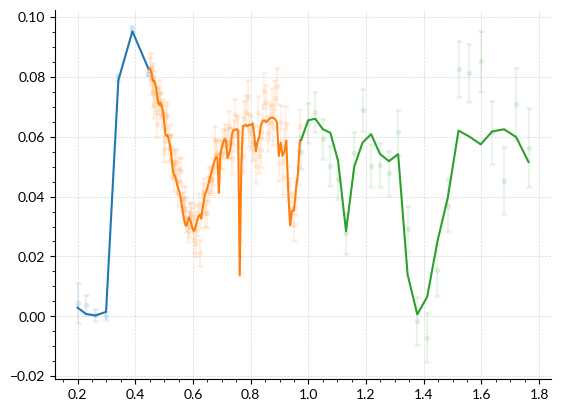

In [5]:
# Just a test...
justplotit(_get_spectra_data(get_config_data()[1], 
                                ["SS-UV", "SS-Vis", "SS-NIR"], 
                                    "../data/tests/modern5pc_habex.npy", distance=10))

In [6]:
save_data_at_51015_distances(stage="modern")
save_data_at_51015_distances(stage="proterozoic")
save_data_at_51015_distances(stage="archean")

# Effect of removing molecule signatures in the spectrum

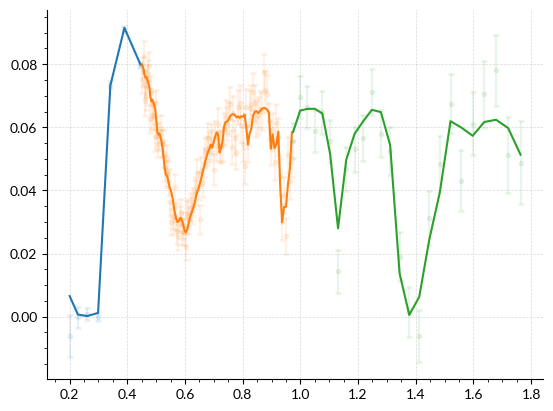

In [7]:
# Just a test...again
justplotit(_get_spectra_data(get_config_data()[1], 
                                ["SS-UV", "SS-Vis", "SS-NIR"], 
                                    "../data/tests/modernwithoutO210pc_habex.npy", distance=10,
                                    gas="O2", multiplier=0))

In [8]:
save_data_without_molecule(stage="modern", gas="02")
save_data_without_molecule(stage="modern", gas="03")